<a href="https://colab.research.google.com/github/marianaabeatrizz/INDICIUM---DESAFIO/blob/main/EDA_Indicium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Exploratória de Dados - Aluguéis em Nova York

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyod
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.iforest import IForest

In [221]:
dados = pd.read_excel('/content/drive/MyDrive/INCIDIUM/Indicium_precificacao.xlsx')

## Inspeção e Limpeza

In [ ]:
dados.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,4075362.0,-7398377.0,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,4080902.0,-739419.0,Private room,150,3,0,NaT,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,4068514.0,-7395976.0,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,4079851.0,-7394399.0,Entire home/apt,80,10,9,2018-11-19,0.1,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,4074767.0,-73975.0,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [ ]:
dados.shape


(48894, 16)

In [ ]:
dados.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,38842,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,3.704803e+06,-6.733035e+06,152.720763,7.030085,23.274758,2018-10-04 01:46:50.710055936,7.144005,112.776169
min,2.595000e+03,2.438000e+03,4.060000e+01,-7.424442e+06,0.000000,1.000000,0.000000,2011-03-28 00:00:00,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,4.068077e+06,-7.398084e+06,69.000000,1.000000,1.000000,2018-07-08 00:00:00,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,4.071686e+06,-7.395212e+06,106.000000,3.000000,5.000000,2019-05-19 00:00:00,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,4.076003e+06,-7.392226e+06,175.000000,5.000000,24.000000,2019-06-23 00:00:00,2.000000,227.000000
max,3.648724e+07,2.743213e+08,4.091306e+06,-7.373000e+01,10000.000000,1250.000000,629.000000,2019-07-08 00:00:00,327.000000,365.000000
std,1.098288e+07,7.861118e+07,1.108312e+06,2.005317e+06,240.156625,20.510741,44.550991,NaN,32.952855,131.618692


In [ ]:
dados_limpo = dados.dropna(subset=['nome']).copy()
dados_limpo = dados_limpo.drop(['host_id', 'host_name'], axis=1, errors='ignore')
dados_limpo = dados_limpo[dados_limpo['price']!= 0]
dados_limpo = dados_limpo[dados_limpo['minimo_noites'] < 365]
dados_limpo = dados_limpo[dados_limpo['disponibilidade_365'] < 365]
dados_limpo['reviews_por_mes'] = pd.to_numeric(dados_limpo['reviews_por_mes'], errors='coerce')
dados_limpo['reviews_por_mes'] = dados_limpo['reviews_por_mes'].fillna(0)
dados_limpo['ultima_review'] = pd.to_datetime(dados_limpo['ultima_review'], errors='coerce')
dados_limpo['ultima_review'] = dados_limpo['ultima_review'].fillna('Sem avaliação')

In [ ]:
dados_limpo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47546 entries, 0 to 48893
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             47546 non-null  int64  
 1   nome                           47546 non-null  object 
 2   bairro_group                   47546 non-null  object 
 3   bairro                         47546 non-null  object 
 4   latitude                       47546 non-null  float64
 5   longitude                      47546 non-null  float64
 6   room_type                      47546 non-null  object 
 7   price                          47546 non-null  int64  
 8   minimo_noites                  47546 non-null  int64  
 9   numero_de_reviews              47546 non-null  int64  
 10  ultima_review                  47546 non-null  object 
 11  reviews_por_mes                47546 non-null  float64
 12  calculado_host_listings_count  47546 non-null  int6

In [ ]:
nulos_por_coluna = dados.isnull().sum()
colunas_com_nulos = nulos_por_coluna[nulos_por_coluna > 0]
print(colunas_com_nulos)



nome                  16
host_name             21
ultima_review      10052
reviews_por_mes    10052
dtype: int64


In [ ]:
porcentagem = (colunas_com_nulos / len(dados)) * 100
print(porcentagem)


nome                0.032724
host_name           0.042950
ultima_review      20.558760
reviews_por_mes    20.558760
dtype: float64


In [ ]:
print(dados['nome'].unique())
print(dados['nome'].value_counts())


['Skylit Midtown Castle' 'THE VILLAGE OF HARLEM....NEW YORK !'
 'Cozy Entire Floor of Brownstone' ...
 'Sunny Studio at Historical Neighborhood'
 '43rd St. Time Square-cozy single bed'
 "Trendy duplex in the very heart of Hell's Kitchen"]
nome
Hillside Hotel                                       18
Home away from home                                  17
New york Multi-unit building                         16
Brooklyn Apartment                                   12
Loft Suite @ The Box House Hotel                     11
                                                     ..
Sunny New Artist's 1BR In Greenpoint                  1
1 BR / studio right by Central Park                   1
2 BEDROOMS, 1 BATH, FULL FRONTAL OCEANVIEW            1
Spacious 1 BR Apartment w/ private backyard           1
Trendy duplex in the very heart of Hell's Kitchen     1
Name: count, Length: 47891, dtype: int64


In [ ]:
dados_limpo = dados_limpo.drop_duplicates(subset=['id'])
dados_limpo['nome']= dados_limpo['nome'].str.lower().str.strip



In [ ]:
dados_limpo.describe()

,id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.754600e+04,4.754600e+04,4.754600e+04,47546.000000,47546.000000,47546.000000,47546.000000,47546.000000,47546.000000
mean,1.901178e+07,3.705169e+06,-6.733433e+06,150.005090,6.418353,23.644281,0.926466,6.985614,105.874984
std,1.095502e+07,1.107862e+06,2.004729e+06,224.956407,13.050497,44.969323,1.516169,32.862121,126.527628
min,2.595000e+03,4.060000e+01,-7.424442e+06,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.484931e+06,4.068091e+06,-7.398086e+06,69.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,1.967367e+07,4.071686e+06,-7.395217e+06,105.000000,2.000000,5.000000,0.240000,1.000000,38.000000
75%,2.910390e+07,4.075998e+06,-7.392264e+06,175.000000,5.000000,24.000000,1.190000,2.000000,204.000000
max,3.648724e+07,4.091306e+06,-7.373000e+01,10000.000000,364.000000,629.000000,58.500000,327.000000,364.000000


id : int64
latitude : float64
longitude : float64
price : int64
minimo_noites : int64
numero_de_reviews : int64
reviews_por_mes : float64
calculado_host_listings_count : int64
disponibilidade_365 : int64


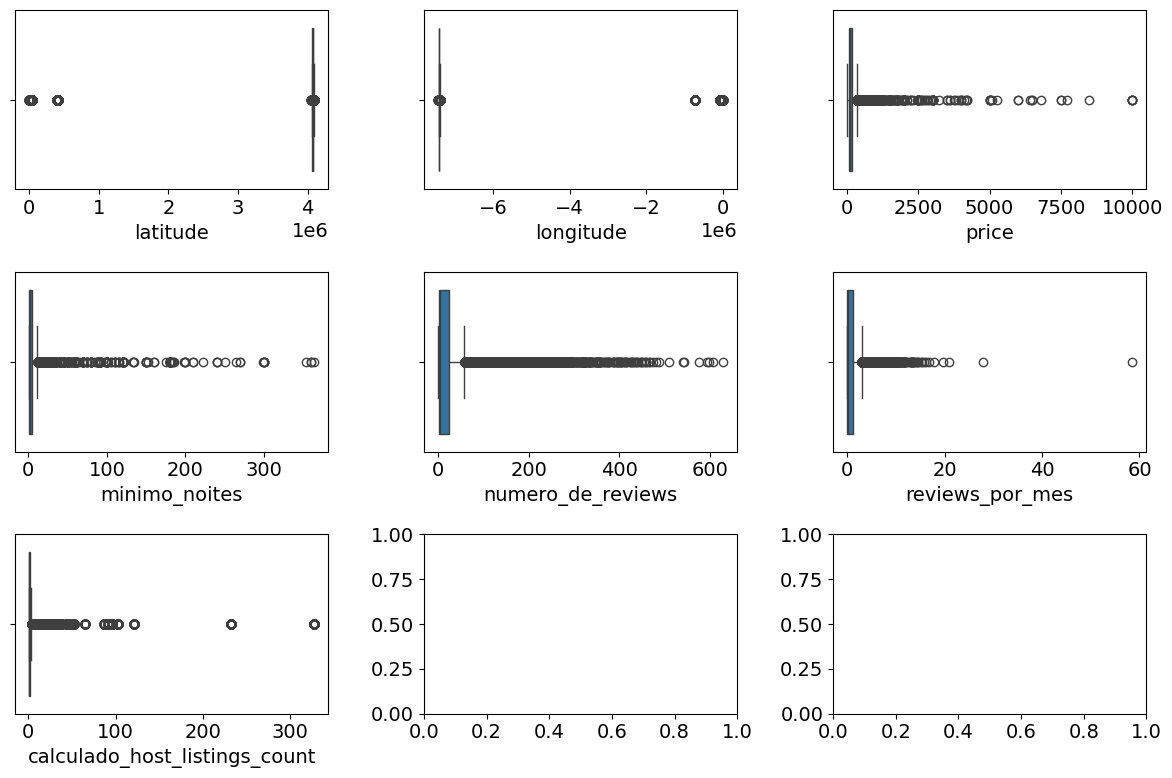

In [ ]:
variaveis_numericas = []
for i in dados_limpo.columns[0:14].tolist():
  if dados_limpo[i].dtype != 'object':
    print(i,':', dados_limpo[i].dtype)
    variaveis_numericas.append(i)

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['figure.autolayout'] = True
plt.rcParams['axes.titlesize'] = 20

f, axes = plt.subplots(3,3)

linha = 0
coluna = 0

for i in variaveis_numericas:
  if i == 'id':
    continue
  elif i =='disponibilidade_365':
    continue
  sns.boxplot(x=dados_limpo[i], ax=axes[linha, coluna])
  coluna += 1
  if coluna > 2:
    coluna = 0
    linha += 1
plt.tight_layout()
plt.show()



In [ ]:
q1 = np.percentile(dados_limpo['minimo_noites'], 25)
q3 = np.percentile(dados_limpo['minimo_noites'], 75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

outliers =[ p for p in dados_limpo['minimo_noites'] if p < limite_inferior or p > limite_superior]
print(f"Limite inferior: {limite_inferior}")
print(f"Limite superior: {limite_superior}")
print(f"Número de outliers: {len(outliers)}")
print(f"Outliers: {outliers}")

Limite inferior: -5.0
Limite superior: 11.0
Número de outliers: 6185
Outliers: [45, 90, 14, 29, 30, 30, 180, 30, 30, 30, 31, 30, 30, 30, 90, 30, 30, 30, 15, 29, 29, 15, 15, 45, 30, 26, 26, 14, 30, 30, 14, 200, 50, 14, 17, 14, 21, 28, 30, 30, 30, 25, 30, 30, 13, 14, 14, 14, 30, 35, 30, 15, 30, 30, 21, 27, 30, 18, 14, 14, 30, 30, 20, 40, 45, 31, 40, 44, 31, 28, 65, 30, 30, 30, 15, 30, 28, 30, 30, 14, 28, 90, 30, 30, 30, 29, 55, 30, 28, 30, 30, 30, 30, 30, 30, 28, 21, 30, 60, 120, 30, 30, 90, 31, 180, 90, 30, 30, 15, 28, 30, 30, 15, 122, 15, 30, 30, 27, 30, 19, 15, 31, 20, 30, 60, 28, 14, 14, 30, 30, 14, 14, 30, 30, 15, 30, 21, 18, 30, 14, 30, 30, 30, 240, 30, 15, 30, 30, 30, 28, 29, 30, 14, 15, 30, 30, 28, 180, 20, 88, 115, 150, 20, 14, 21, 20, 90, 30, 28, 14, 15, 30, 30, 30, 30, 30, 31, 14, 30, 30, 30, 30, 30, 30, 30, 14, 30, 14, 30, 30, 30, 30, 30, 14, 20, 14, 30, 90, 30, 30, 28, 45, 19, 30, 40, 60, 30, 30, 60, 30, 14, 14, 20, 31, 30, 28, 30, 30, 14, 30, 30, 14, 30, 14, 30, 20, 20, 30,

In [ ]:
media = np.mean(dados_limpo['minimo_noites'])
desvio_padrao = np.std(dados_limpo['minimo_noites'])


limite_inferior = media - 3 * desvio_padrao
limite_superior = media + 3 * desvio_padrao

outliers = [valor for valor in dados_limpo['minimo_noites'] if valor < limite_inferior or valor > limite_superior]
print("Média:", media)
print("Desvio padrão:", desvio_padrao)
print("Limite inferior:", limite_inferior)
print("Limite superior:", limite_superior)
print("Outliers:", outliers)

Média: 6.418352753123291
Desvio padrão: 13.050360106374905
Limite inferior: -32.73272756600142
Limite superior: 45.56943307224801
Outliers: [90, 180, 90, 200, 50, 65, 90, 55, 60, 120, 90, 180, 90, 122, 60, 240, 180, 88, 115, 150, 90, 90, 60, 60, 80, 181, 90, 80, 265, 300, 180, 60, 59, 185, 60, 360, 90, 60, 90, 50, 70, 120, 120, 120, 115, 120, 59, 80, 60, 110, 60, 90, 90, 90, 60, 200, 90, 270, 60, 150, 50, 75, 250, 60, 110, 60, 180, 75, 62, 60, 60, 70, 90, 60, 60, 364, 74, 180, 200, 50, 198, 100, 60, 60, 90, 100, 90, 90, 180, 120, 90, 60, 60, 91, 100, 100, 60, 60, 59, 60, 90, 120, 60, 120, 60, 60, 120, 90, 60, 56, 80, 180, 90, 99, 55, 160, 60, 90, 47, 90, 60, 180, 90, 60, 90, 90, 180, 50, 120, 120, 60, 180, 150, 60, 180, 120, 90, 60, 80, 60, 180, 90, 90, 90, 68, 90, 120, 270, 60, 90, 90, 120, 99, 70, 90, 50, 60, 91, 120, 90, 120, 60, 60, 75, 93, 100, 100, 180, 60, 120, 90, 150, 60, 90, 60, 90, 47, 90, 90, 60, 180, 300, 50, 90, 59, 90, 87, 50, 90, 90, 300, 120, 180, 183, 90, 90, 62, 60, 

In [ ]:
len(outliers)

378

In [ ]:
dados_limpo = dados_limpo[(dados_limpo['minimo_noites'] > limite_inferior) & (dados_limpo['minimo_noites'] <= limite_superior)]

In [ ]:
dados_limpo.shape

(47168, 14)

In [ ]:
dados_limpo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47168 entries, 0 to 48893
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             47168 non-null  int64  
 1   nome                           47168 non-null  object 
 2   bairro_group                   47168 non-null  object 
 3   bairro                         47168 non-null  object 
 4   latitude                       47168 non-null  float64
 5   longitude                      47168 non-null  float64
 6   room_type                      47168 non-null  object 
 7   price                          47168 non-null  int64  
 8   minimo_noites                  47168 non-null  int64  
 9   numero_de_reviews              47168 non-null  int64  
 10  ultima_review                  47168 non-null  object 
 11  reviews_por_mes                47168 non-null  float64
 12  calculado_host_listings_count  47168 non-null  int6

##Relações e Hipóteses

In [ ]:
!pip install scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
dados_limpo.columns

Index(['id', 'nome', 'bairro_group', 'bairro', 'latitude', 'longitude',
       'room_type', 'price', 'minimo_noites', 'numero_de_reviews',
       'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365'],
      dtype='object')

Mean Squared Error (MSE): 0.3759305629930734
Mean Absolute Error (MAE): 0.48491274754375324
R²: 0.06590935184888891


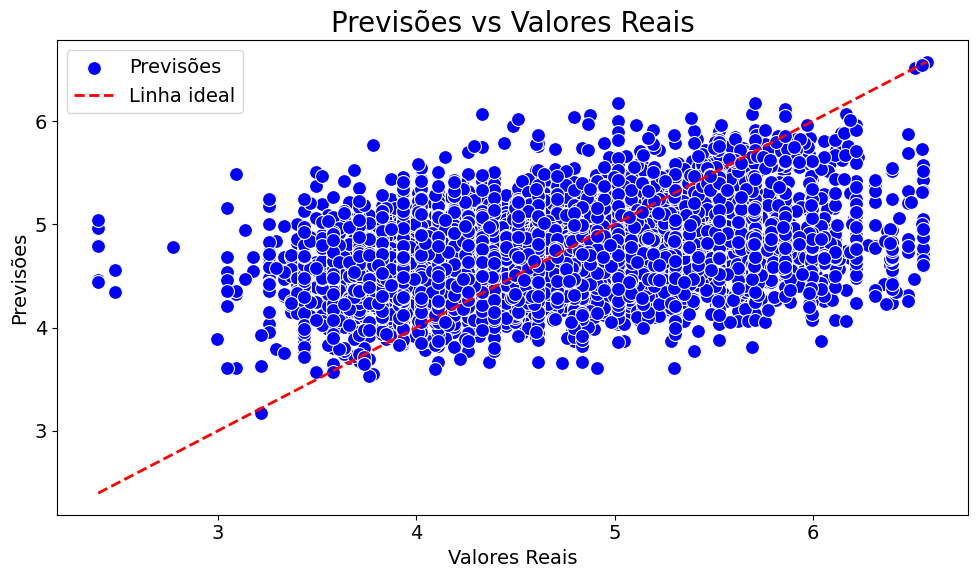

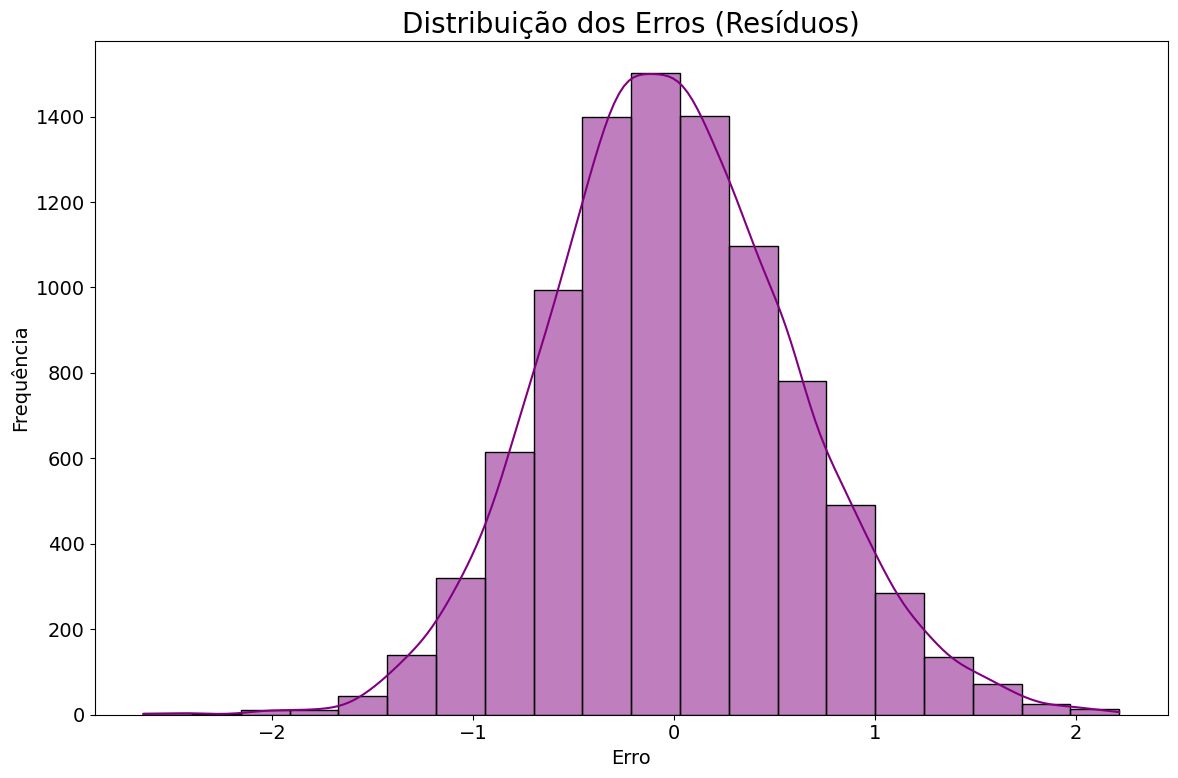

Média dos resíduos: -0.005612405404788689


In [214]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Carregar os dados (supondo que 'dados_limpo' já está carregado)
dados = pd.DataFrame(dados_limpo)

# Remover outliers nos preços (considerando valores acima do percentil 99)
limite_superior = dados['price'].quantile(0.99)
dados = dados[dados['price'] <= limite_superior]

# Transformação logarítmica no preço para reduzir impacto de outliers
dados['price'] = np.log1p(dados['price'])

# Selecionando variáveis
X = dados[['minimo_noites','numero_de_reviews','reviews_por_mes','calculado_host_listings_count','disponibilidade_365']]
y = dados['price']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalonamento das variáveis
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinando um modelo mais robusto (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R²: {r2}')

# Gráficos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Previsões', s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Linha ideal")
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões vs Valores Reais')
plt.legend()
plt.show()

# Distribuição dos erros (resíduos)
residuos = y_test - y_pred
sns.histplot(residuos, kde=True, color='purple', bins=20)
plt.title('Distribuição dos Erros (Resíduos)')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.show()

# Média dos resíduos
erro_medio = np.mean(residuos)
print(f'Média dos resíduos: {erro_medio}')

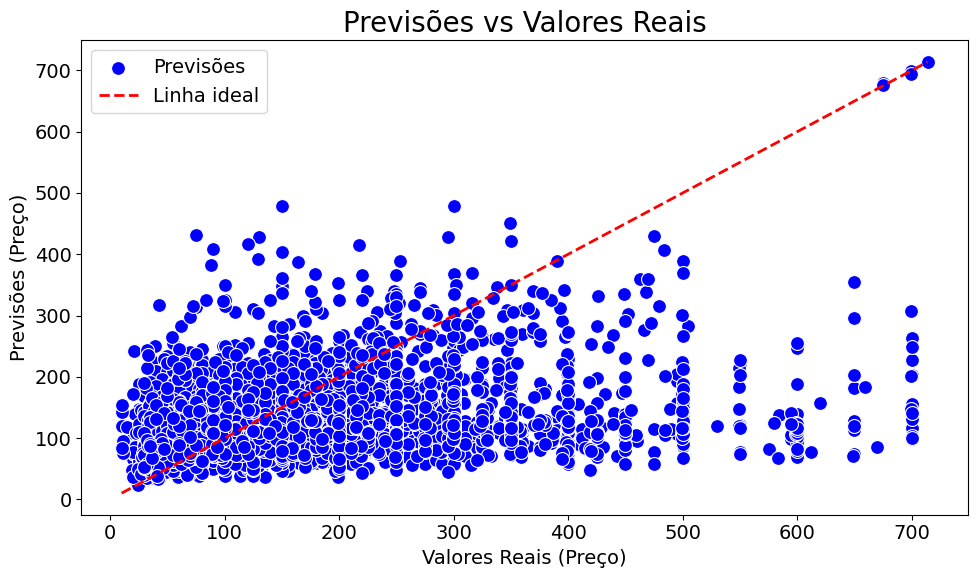

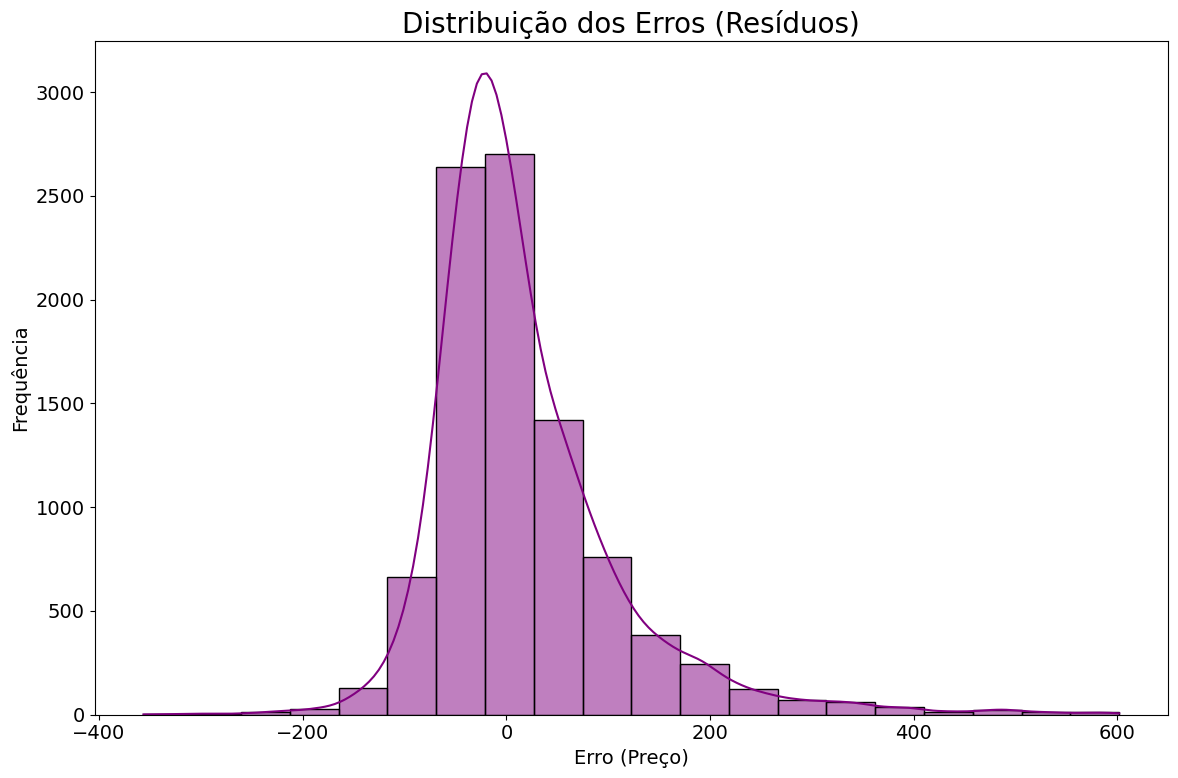

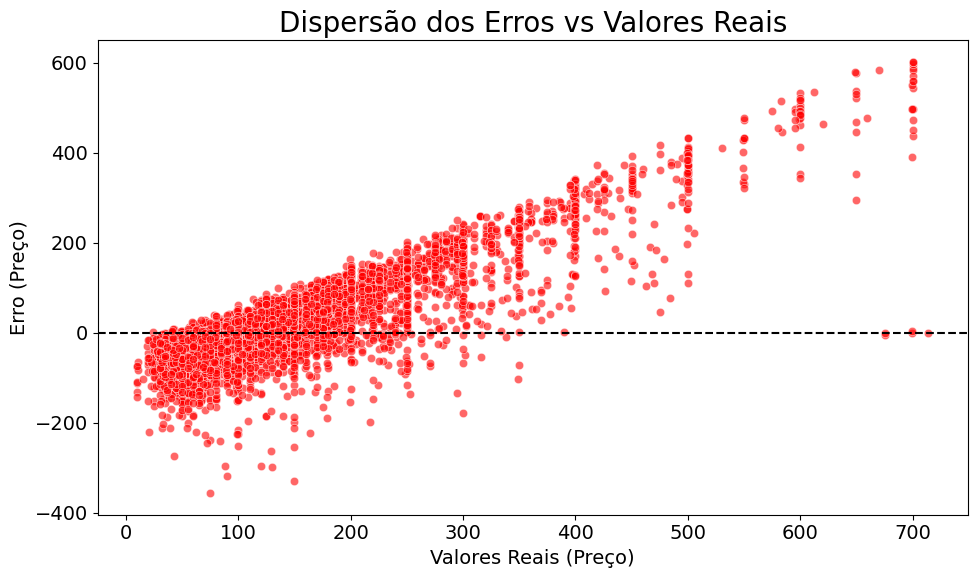

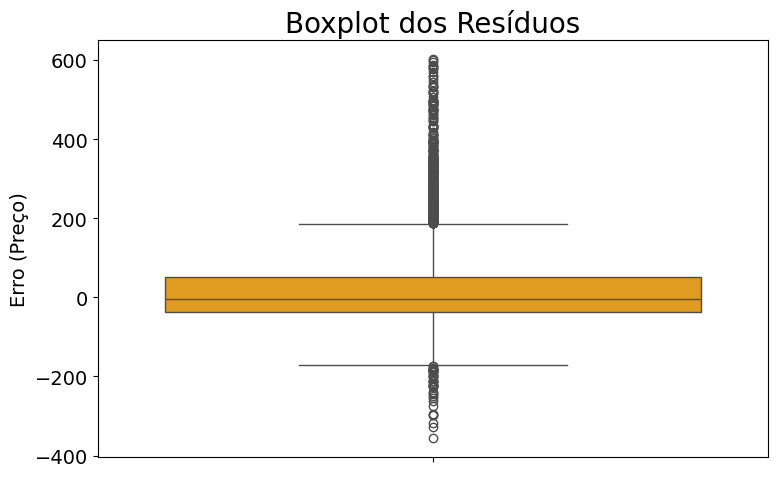

In [ ]:
y_test = np.expm1(y_test)
y_pred = np.expm1(y_pred)

#Gráfico de Previsões vs. Valores Reais
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Previsões', s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Linha ideal")
plt.xlabel('Valores Reais (Preço)')
plt.ylabel('Previsões (Preço)')
plt.title('Previsões vs Valores Reais')
plt.legend()
plt.show()

# Gráfico de distribuição dos erros (resíduos)
residuos = y_test - y_pred
sns.histplot(residuos, kde=True, color='purple', bins=20)
plt.title('Distribuição dos Erros (Resíduos)')
plt.xlabel('Erro (Preço)')
plt.ylabel('Frequência')
plt.show()

# Gráfico de dispersão dos resíduos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuos, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Valores Reais (Preço)')
plt.ylabel('Erro (Preço)')
plt.title('Dispersão dos Erros vs Valores Reais')
plt.show()

# Boxplot dos resíduos
plt.figure(figsize=(8, 5))
sns.boxplot(y=residuos, color='orange')
plt.title('Boxplot dos Resíduos')
plt.ylabel('Erro (Preço)')
plt.show()




## Valor sugerido para o Skylit Midtown Castle suposto no item 4

In [ ]:
import json

def prever_preco(json_input):
    # Converter JSON para DataFrame
    dados_input = pd.DataFrame([json.loads(json_input)])

    # Aplicar o mesmo escalonamento usado no treinamento
    dados_input = scaler.transform(dados_input)

    # Fazer a previsão
    preco_previsto = model.predict(dados_input)

    # Reverter transformação logarítmica
    preco_previsto = np.expm1(preco_previsto)

    return preco_previsto[0]

# Sugestão de preço para o apartamento com as características sugeridas no item 4 :
json_exemplo = json.dumps({
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355
})

preco = prever_preco(json_exemplo)
print(f"Preço previsto: {preco:.2f}")

Preço previsto: 165.19


  O problema resolvido trata-se de uma regressão linear, dado pelo pela busca do preço da hospedagem, que é um valor contínuo. As variável depende é representada pelo preço e as independentes são as que representam o número mínimo de noites, número de avaliações, frequência de avaliações, o número de imóveis do anfitrião e a disponibilidade do local ao longo de um ano.

  As transformações aplicadas incluem a remoção de outliers(exclusão de valores acima do percentil 99) como forma de evitar que valores extremos afetem o modelo, a transformação logarítmica também foi utilizada para reduzir a assimetra que atrapalhou tentativas anteriores de representação gráfica, também houve o uso do StandardScaler(), com o objetivo de padronizar as variáveis com a garantia de variância unitária e média zero.

  Quanto ao modelo escolhido, foi levada em consideração para uso a robustez a outliers e captura de relações não lineares e uma boa generalização, com isso, foi escolhido o Random Forest Regressor - algoritmo de aprendizado de máquina baseado em árvores de decisão, - para este projeto. O contra do algoritmo estão no fato dele ser mais lento em grande volumes de dados, pois constrói várias árvores de decisões para fazer previsões combinadas entre elas.

  Métricas para avaliação de desempenho:

  Mean Squared Error (MSE): Penaliza erros grandes, mas é sensível a outliers.

  Mean Absolute Error (MAE): Indica o erro médio absoluto das previsões, útil para interpretação direta.

  R² Score: Mede a proporção da variância dos dados explicada pelo modelo.

  Por fim, foi implementada uma função prever_preco(), que recebe um JSON com os atributos do imóvel, transforma os dados para o mesmo formato do modelo e faz a previsão do preço, revertendo a transformação logarítmica.



## O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

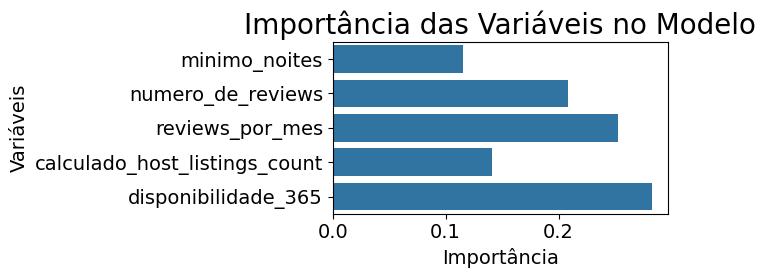

In [ ]:
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(7,3))
sns.barplot(x=importances, y=feature_names)
plt.xlabel("Importância")
plt.ylabel("Variáveis")
plt.title("Importância das Variáveis no Modelo")
plt.show()


Com a análise individual das váriaveis em relação ao impacto que elas têm no preço, percebe-se que a variável que representa o **mínimo de noites** possui a menor relevância na definição do preço de um imóvel em Nova York, o que pode demonstrar que restrições rígidas levam a possíveis períodos de vacância, especialmente em um mercado com muitas opções com estadias mínimas menores, além de limitar o público alvo, muitas vezes afastando turistas que ficarão por um curto período de tempo. Por outro lado, a variável de **disponibilidade** possui a maior relevância no modelo ML.Uma hipótese é de que a alta disponibilidade beneficia tanto aos viajantes que se planejam com antecedência, quanto os que se planejam de última hora, além de que, por estarem disponíveis durante praticamente todo o ano, aumentam as chances de serem reservados.

In [ ]:
dados['interacao_noites_disponibilidade'] = dados['minimo_noites'] * dados['disponibilidade_365']
print(dados[['interacao_noites_disponibilidade', 'price']].corr())



                                  interacao_noites_disponibilidade     price
interacao_noites_disponibilidade                          1.000000  0.084986
price                                                     0.084986  1.000000


A análise da correlação entre a interação das variáveis mínimo de noites e disponibilidade (365 dias) com o preço revelou um coeficiente de 0,087. Esse valor indica uma correlação positiva, porém muito fraca, entre a interação dessas variáveis e o preço. Ou seja, embora exista uma relação direta, a influência combinada dessas duas variáveis no preço não é significativa. Esse resultado pode indicar que, enquanto a disponibilidade sozinha tem um impacto maior no preço, a exigência de um número mínimo de noites reduz sua relevância na precificação, já que limita a flexibilidade para diferentes perfis de viajantes. Portanto, embora ambas sejam importantes de forma isolada, sua interação não explica de maneira expressiva as variações no preço dos imóveis.

## O nome do local influencia no preço?

In [234]:
top_names = high_value_listings["nome"].value_counts().head(20)
print(top_names)


nome
Loft Suite @ The Box House Hotel                      11
IN MINT CONDITION-STUDIOS EAST 44TH/UNITED NATIONS     6
A CLASSIC NYC NEIGHBORHOOD-EAST 86TH/5TH AVENUE        5
WEST VILLAGE Bohemian flat in neo-Tudor town house     5
New york Multi-unit building                           5
West Village Apartment                                 5
Sonder | The Biltmore | Spacious 1BR + Kitchen         4
Are You Ready for Central Park State of Mind?          4
SPECTACULAR LOFT OVERLOOKING THE MANHATTAN SKYLINE     4
Loft Suite @ Box House Hotel                           4
Sixth Ave Chelsea, Studio Serviced Apartment           3
Sixth Ave Chelsea, 1bd Serviced Apartment              3
Charming East Village Apartment                        3
Manhattan Club                                         3
West 55th street, Lux 1bd Serviced Apartment           3
Studio Penthouse                                       3
East 63rd street, Studio Serviced Apartment            3
Superior @ Box House      

##Insights de Negócio para o nome do imóvel:

**Estratégia de Nomeação**

Proprietários podem otimizar o nome dos seus imóveis incluindo palavras como Luxury, Spacious, Modern, e referências geográficas estratégicas (Midtown, Central).

**Valorização por Localização**

Usar nomes que enfatizam bairros desejados (Manhattan, Williamsburg) pode atrair hóspedes dispostos a pagar mais.

**Destaque para o Tipo de Imóvel**

Descrever claramente se é um Loft, Studio ou Apartment pode ajudar a alinhar expectativas e aumentar conversões.

##Ideias de Negócios e hipóteses com base nas análises

**Divisão territorial de Nova York:**

Nova York é composta por cinco grandes distritos, conhecidos como boroughs, cada um com sua identidade própria e características marcantes:

Manhattan  – O coração financeiro e cultural da cidade, abriga a Times Square, Wall Street e o Central Park. É a região mais cara e turística.

Brooklyn  – Conhecido por sua cena artística e bairros históricos, como Williamsburg e DUMBO. Oferece uma mistura de modernidade e tradição.

Queens  – O mais diverso culturalmente, abriga os aeroportos JFK e LaGuardia, além de ser um polo gastronômico incrível.

The Bronx  – Berço do hip-hop e lar do famoso estádio dos Yankees, tem uma forte identidade cultural e artística.

Staten Island  – A área mais suburbana, conhecida por seus parques e tranquilidade, acessível por meio do Staten Island Ferry.



**Correlação entre Preço e Localização**

Hipótese: Imóveis em Manhattan são, em média, mais caros do que os de Brooklyn e outras áreas.

-> Estratégia: Ajustar preços para maximizar ocupação e receita, oferecendo descontos em períodos de baixa demanda.

**Impacto do Número de Avaliações no Preço**

Hipótese: Imóveis com mais avaliações tendem a ter preços mais altos e ocupação mais frequente.

-> Estratégia: Incentivar hóspedes a deixarem avaliações para aumentar a credibilidade e justificar preços premium.

**Disponibilidade e Rentabilidade**

Hipótese: Imóveis disponíveis durante todo o ano possuem preços mais competitivos para garantir ocupação contínua.

-> Estratégia: Criar políticas de precificação dinâmica com descontos para estadias mais longas ou last-minute.